<h1>Exploring the data</h1>

<h2>Loading the data</h2>

In [1]:
import os

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

<h2>Data preparation</h2>

In [2]:
from math import sqrt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
complete_graph_list = []
for i in range(101):
    for j in range(101):
        if i != j:
            complete_graph_list.append([i,j])
edge_index = torch.tensor(complete_graph_list, dtype=torch.long).t().contiguous()
n_edges = len(complete_graph_list)

In [4]:
for instance_name in ng_dict:
    for i in range(101):
        for j in range(101):
            if i == j:
                ng_dict[instance_name][i][j] = 0

In [5]:
data_list = []
for instance_name in ng_dict:
    y = torch.tensor(ng_dict[instance_name], dtype=torch.double)
    x = torch.tensor(instance_dict[instance_name], dtype=torch.double)
    attr = [[i] for i in range(n_edges)]
    loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) for i in instance_dict[instance_name] for j in instance_dict[instance_name]}
    cnt = -1
    for i in range(101):
        for j in range(101):
            if i != j:
                cnt += 1
                attr[cnt].append(loc_dict[i,j])
    attr = torch.tensor(attr, dtype=torch.double)
    pos = []
    for i in instance_dict[instance_name]:
        pos.append([i[1], i[2]])
    pos = torch.tensor(pos, dtype=torch.double)
    data_list.append(Data(x=x, y=y, edge_index=edge_index, pos=pos, edge_attr=attr))

In [6]:
# Just to produce edges as an adjacency matrix
complete_adj_matrix_list = [[0 for i in range(101)] for i in range(101)]
for edge in complete_graph_list:
    i, j = edge
    complete_adj_matrix_list[i][j] = 1

In [7]:
class Instances:
    def __init__(self, data_list):
        self.data_list = data_list
    
    def to_torch_geometric(self, start=0, end=-1, batch_size=1):
        return DataLoader(data_list[start:end], batch_size=batch_size)
    
    def to_conv_nets(self, start=0, end=-1, batch_size=1):
        final_data = []
        nodes = []
        nodes_coor = []
        nodes_timew = []
        x_edges = []
        x_edges_values = []
        y_edges = []
        cnt = 0
        current_batch = 0
        for graph in self.data_list[start:end]:
            if cnt >= batch_size:
                cnt = 0
                current_batch += 1
                nodes = torch.tensor(nodes, dtype=torch.long)
                nodes_coor = torch.tensor(nodes_coor, dtype=torch.float)
                nodes_timew = torch.tensor(nodes_timew, dtype=torch.long)
                x_edges = torch.tensor(x_edges, dtype=torch.long)
                x_edges_values = torch.tensor(x_edges_values, dtype=torch.float)
                y_edges = torch.tensor(y_edges, dtype=torch.long)
                final_data.append((x_edges, x_edges_values, nodes, nodes_coor, nodes_timew, y_edges))
                nodes = []
                nodes_coor = []
                nodes_timew = []
                x_edges = []
                x_edges_values = []
                y_edges = []
            nodes.append([i for i in range(101)]) 
            nodes_coor.append(graph.pos.tolist())
            tw = []
            x_raw = graph.x.tolist()
            for i in range(101):
                tw.append([x_raw[i][4], x_raw[i][5]])
            nodes_timew.append(tw)
            x_edges.append(complete_adj_matrix_list)
            dist_matrix = [[0 for _ in range(101)] for _ in range(101)]
            dist_list = [i for _, i in graph.edge_attr.tolist()]
            pos_dist = 0
            for i in range(101):
                for j in range(101):
                    if i != j:
                        dist_matrix[i][j] = dist_list[pos_dist]
                        pos_dist += 1
            x_edges_values.append(dist_matrix)
            y_edges.append(graph.y.tolist()) #TODO: remove the transpose and also the contiguous when generating y
            cnt += 1
        return final_data

In [8]:
data_source = Instances(data_list)

In [9]:
datatorch = data_source.to_conv_nets(start=428, end=430, batch_size=1)

In [10]:
x_edges, x_edges_values, nodes, nodes_coor, nodes_timew, y_edges = datatorch[0]

In [11]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import networkx as nx

In [12]:
G = nx.Graph()
G.add_nodes_from([i for i in range(101)])
pos = {i:(int(nodes_coor[0][i][0]), int(nodes_coor[0][i][1])) for i in range(101)}

In [13]:
tw_dict = {i:(int(nodes_timew[0][i][0]), int(nodes_timew[0][i][1]), int(nodes_timew[0][i][1]) - int(nodes_timew[0][i][0])) for i in range(101)}

In [21]:
print(list(range(0,max(tw_dict.items(), key=lambda x: x[1][1])[1][1], min(tw_dict.items(), key=lambda x: x[1][2])[1][2])))

[0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140]


In [131]:
# print(min(tw_dict.items(), key=lambda x: x[1][2])[1][2])
window_length = min(tw_dict.items(), key=lambda x: x[1][2])[1][2]
max_time = max(tw_dict.items(), key=lambda x: x[1][1])[1][1] + window_length
t_dict = {}
for t in range(0, max_time, window_length):
    valid_nodes = []
    for i in range(101):
        if tw_dict[i][0] <= t and tw_dict[i][1] >= t:
            valid_nodes.append(i)
    t_dict[t] = valid_nodes

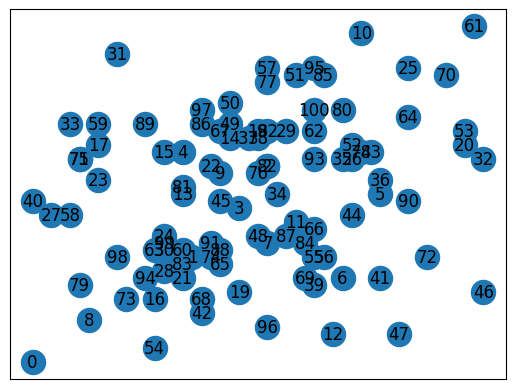

In [24]:
nx.draw_networkx(G, pos=pos)
plt.show()

In [25]:
edge_x = []
edge_y = []
for i in range(101):
    for j in range(101):
        if y_edges[0][i][j] > 0.5:
            x0, y0 = pos[i]
            x1, y1 = pos[j]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)
            G.add_edge(i,j)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))



In [26]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Ng-Neighborhoods as a graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=800)
                
                )
fig.show()

In [132]:

G = nx.Graph()
G.add_nodes_from([i for i in range(101)])
# Create figure
fig = go.Figure()

edgex_dict = {}
edgey_dict = {}

for t in t_dict:
    edge_x = []
    edge_y = []
    for i in range(101):
        if i in t_dict[t]:
            for j in range(101):
                if j in t_dict[t]:
                    if y_edges[0][i][j] > 0.5:
                        x0, y0 = pos[i]
                        x1, y1 = pos[j]
                        edge_x.append(x0)
                        edge_x.append(x1)
                        edge_x.append(None)
                        edge_y.append(y0)
                        edge_y.append(y1)
                        edge_y.append(None)
                        G.add_edge(i,j)
    edgex_dict[t] = edge_x
    edgey_dict[t] = edge_y



enum_dict = {}
for _, b in enumerate(G.adjacency()):
    enum_dict[b[0]] = list(b[1].keys())

nodex_dict = {}
nodey_dict = {}
node_adj_dict = {}
node_text_dict = {}
for t in t_dict:
    node_x = []
    node_y = []
    node_adjacencies = []
    node_text = []
    for node in G.nodes():
        if node in t_dict[t]:
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_adjacencies.append(len(enum_dict[node]))
            ng_set = []
            for j in range(101):
                if y_edges[0][node][j] > 0.5:
                    ng_set.append(j)
            node_text.append('Node '+str(node)+', # of connections: '+str(len(enum_dict[node])) + ', NG-Set='+str(ng_set))
    nodex_dict[t] = node_x
    nodey_dict[t] = node_y
    node_adj_dict[t] = node_adjacencies
    node_text_dict[t] = node_text

# node_adjacencies = []
# node_text = []
# for node, adjacencies in enumerate(G.adjacency()):
#     node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('# of connections: '+str(len(adjacencies[1])))

# node_trace.marker.color = node_adjacencies
# node_trace.text = node_text

for window in t_dict:
    fig.add_trace(
    	go.Scatter(
            visible=False,
            name="v = " + str(window),
            x=nodex_dict[window], y=nodey_dict[window],
            mode='markers',
            hoverinfo='text',
            text = node_text_dict[window],
            marker=dict(
                showscale=True,
                # colorscale options
                #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale='YlGnBu',
                reversescale=True,
                color=node_adj_dict[window],
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2)
            )
    )

for window in t_dict:
    fig.add_trace(
        go.Scatter(
            visible=False,
            x=edgex_dict[window], y=edgey_dict[window],
            # line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            # mode='lines',
            name="e = " + str(window),
            marker=dict(size=9,symbol= "arrow-bar-up", angleref="previous", color='#888')
        )
    )

fig.data[2].visible = True
fig.data[len(t_dict) + 2].visible = True



print(edgex_dict)
print(edgey_dict)

{0: [], 60: [50, 46, None, 46, 46, None, 34, 29, None, 45, 50, None, 46, 45, None, 56, 45, None, 45, 46, None, 43, 41, None, 41, 45, None, 55, 46, None], 120: [], 180: [61, 50, None, 53, 50, None, 55, 54, None, 54, 55, None, 50, 55, None, 55, 50, None], 240: [39, 38, None, 25, 29, None, 29, 25, None, 38, 39, None], 300: [31, 38, None, 59, 59, None, 48, 41, None, 59, 59, None, 55, 48, None], 360: [], 420: [49, 46, None, 71, 60, None, 62, 60, None, 46, 49, None, 50, 49, None, 30, 41, None, 60, 62, None, 43, 49, None], 480: [44, 43, None, 41, 34, None, 34, 41, None], 540: [62, 59, None, 50, 53, None, 53, 50, None, 52, 59, None, 45, 50, None], 600: [43, 35, None, 71, 65, None, 65, 71, None, 35, 43, None], 660: [47, 49, None, 49, 47, None], 720: [32, 45, None, 55, 50, None, 49, 55, None, 50, 55, None], 780: [56, 65, None], 840: [58, 65, None, 65, 58, None], 900: [38, 37, None, 32, 41, None, 30, 37, None, 41, 39, None, 52, 44, None, 37, 39, None], 960: [], 1020: [], 1080: [], 1140: [], 1200:

In [133]:
steps = []
for i in range(len(t_dict)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "<br>Ng-Neighborhoods as a graph. Available at t: " + str(i*window_length)}],  # layout attribute
        label=str(i*60)
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][len(t_dict) + i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=1,
    currentvalue={"prefix": "Time around: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='<br>Ng-Neighborhoods as a graph',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    annotations=[ dict(
        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002 ) ],
    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
    height=800,
    width=1600,
    sliders=sliders
)

fig.update_xaxes(range=[0, 100], minallowed=0)
fig.update_yaxes(range=[0, 100], maxallowed=100)

# layout=go.Layout(
#                 title='<br>Ng-Neighborhoods as a graph',
#                 titlefont_size=16,
#                 showlegend=False,
#                 hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
#                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                 height=800)

fig.show()

In [16]:
ng_set_dict_by_element = {}
ng_set = {}
for i in range(101):
    for j in range(101):
        if y_edges[0][i][j] > 0.5:
            if j not in ng_set_dict_by_element:
                ng_set_dict_by_element[j] = {"neighbors":[], "edge_x": [], "edge_y": []}
            if i not in ng_set:
                ng_set[i] = []
            ng_set_dict_by_element[j]["neighbors"].append(i)
            ng_set[i].append(j)
            x0, y0 = pos[i]
            x1, y1 = pos[j]
            ng_set_dict_by_element[j]["edge_x"].append(x0)
            ng_set_dict_by_element[j]["edge_x"].append(x1)
            ng_set_dict_by_element[j]["edge_x"].append(None)
            ng_set_dict_by_element[j]["edge_y"].append(y0)
            ng_set_dict_by_element[j]["edge_y"].append(y1)
            ng_set_dict_by_element[j]["edge_y"].append(None)
            G.add_edge(i,j)

In [17]:
def getRGBfromI(RGBint):
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue

In [18]:
getRGBfromI(255*255*255//100)

(2, 135, 181)

In [41]:
edge_trace = []
for key, val in ng_set_dict_by_element.items():
    edge_x = val["edge_x"]
    edge_y = val["edge_y"]
    r, g, b = getRGBfromI(key*255*255*255//100)
    edge_subtrace = go.Scatter(
        x=edge_x, y=edge_y,
        # line=dict(width=1, color="rgb({},{},{})".format(r, g, b)),
        hoverinfo='none',
        # mode='lines',
        marker=dict(size=9,symbol= "arrow-bar-up", angleref="previous", color="rgb({},{},{})".format(r, g, b))
    )
    edge_trace.append(edge_subtrace)

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [42]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('Node '+str(node)+', # of connections: '+str(len(adjacencies[1]))+(", being neighbor of : "+str(ng_set_dict_by_element[node]["neighbors"]) if node in ng_set_dict_by_element else "") + (", NG : "+str(ng_set[node]) if node in ng_set else ""))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig2 = go.Figure(data=[node_trace],
             layout=go.Layout(
                title='<br>Ng-Neighborhoods as a graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=800)
                
                )
for subtrace in edge_trace:
    fig2.add_trace(subtrace)
fig2.show()